In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

## 1. Importing Compass
#### Installation
Clone the repository and install the required dependencies:
```bash
git clone https://github.com/mims-harvard/COMPASS.git
cd Immune-compass
pip install -r requirements.txt
```

#### Adding Compass to Your Environment
Before importing compass, add it to your Python path:

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/COMPASS/')
from compass import PreTrainer, FineTuner, loadcompass

## 2. Making Predictions with a Compass Model


You can download all available Compass fine-tuned models [here](https://www.immuno-compass.com/download/) for prediction.

The input `df_tpm` is gene expression tabular data. Please refer [here](https://www.immuno-compass.com/help/index.html#section1) for details on generating input data. The first column represents the cancer code, while the remaining 15,672 columns correspond to genes. Each row represents one patient. An example input file can be downloaded [here](https://www.immuno-compass.com/download/other/compass_gide_tpm.tsv).

The output `df_pred` contains two columns, where `0` indicates non-response and `1` indicates response.





In [3]:
df_tpm = pd.read_csv('./data/compass_gide_tpm.tsv', sep='\t', index_col=0)
#download a compass model from https://www.immuno-compass.com/download/model/LOCO/pft_leave_Gide.pt 
model = loadcompass('./model/pft_leave_Gide.pt', map_location = 'cpu')
# Use map_location = 'cpu' if you dont have a GPU card
_, df_pred = model.predict(df_tpm, batch_size=128)

100%|##########| 1/1 [00:09<00:00,  9.08s/it]


In [4]:
df_pred.head()

,0,1
Index,,
1_ipiPD1_PRE,0.429565,0.570435
2_ipiPD1_PRE,0.999955,0.000045
6_ipiPD1_PRE,0.224929,0.775071
7_ipiPD1_PRE,0.004783,0.995217
8_ipiPD1_PRE,0.841231,0.158769



## 3. Extracting Features with a Compass Model

Both pre-trained (PT) and fine-tuned (FT) Compass models can function as feature extractors. The extracted gene-level, geneset-level, or cell type/pathway-level features can be used to build a logistic regression model for response prediction or a Cox regression model for survival prediction.


In [5]:
# Use any Compass model of your choice
model = loadcompass('./model/pretrainer.pt') 
#downloaded from https://www.immuno-compass.com/download/model/pretrainer.pt 
dfgn, dfgs, dfct = model.extract(df_tpm, batch_size=128, with_gene_level=True)
dfct.head()

100%|##########| 1/1 [00:00<00:00,  1.19it/s]


,CANCER,Bcell_general,Memory_Bcell,Naive_Bcell,Plasma_cell,CD4_Tcell,CD8_Tcell,Memory_Tcell,Naive_Tcell,Tcell_general,...,Pancreatic,Pneumocyte,Apoptosis_pathway,IFNg_pathway,TGFb_pathway,Cytokine,Cell_proliferation,TLS,Genome_integrity,Reference
Index,,,,,,,,,,,,,,,,,,,,,
1_ipiPD1_PRE,-0.757586,-0.262867,0.129370,-0.815162,0.278603,-0.169692,-0.026435,0.039869,-0.401233,-0.215705,...,0.099943,-0.063546,0.120870,-0.268174,-0.081785,-0.072616,-0.136177,-0.176708,0.152991,0.453108
2_ipiPD1_PRE,-0.757746,-0.353675,0.393750,-0.811435,0.074256,-0.185324,-0.012123,0.077559,0.536754,-0.107892,...,0.080122,0.034633,0.113858,-0.265196,0.024003,-0.092963,-0.140686,-0.014389,0.203304,0.457289
6_ipiPD1_PRE,-0.757299,-0.372067,0.161556,-0.798404,0.103220,-0.161113,0.021997,0.145440,0.043221,-0.112898,...,0.070483,-0.081517,0.147193,-0.191045,-0.072711,-0.065004,-0.167961,-0.164095,0.135996,0.448622
7_ipiPD1_PRE,-0.757101,-0.242434,0.178155,-0.803801,0.206927,-0.183297,0.033455,0.059158,-0.426837,-0.106407,...,0.026826,-0.105330,0.239903,-0.129926,-0.094376,-0.052420,-0.149514,-0.147732,0.146455,0.431817
8_ipiPD1_PRE,-0.758030,-0.396814,0.197401,-0.809641,0.081464,-0.181386,0.056288,0.205693,-0.000701,-0.137546,...,0.151547,-0.056724,0.052763,-0.204880,-0.098621,-0.074825,-0.063258,-0.099110,0.141699,0.468105


The outputs `dfgn`, `dfgs`, and `dfct` correspond to gene-level (15,672), geneset-level (133), and concept-level (44) features, respectively. The extracted features are scalar scores. If you need vector features (dim=32), use the following method:

In [6]:
dfgs, dfct = model.project(df_tpm, batch_size=128)
dfct.head()

100%|##########| 1/1 [00:00<00:00,  2.23it/s]


,channel_0,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,...,channel_22,channel_23,channel_24,channel_25,channel_26,channel_27,channel_28,channel_29,channel_30,channel_31
1_ipiPD1_PRE$$Bcell_general,-0.034739,-0.332635,-0.642141,0.561939,0.020290,0.367835,0.518909,0.365392,0.175236,-0.415692,...,-0.021645,-0.236544,-0.747826,0.391741,-1.088722,0.756434,0.211727,-0.244743,0.848020,0.388430
1_ipiPD1_PRE$$Memory_Bcell,-0.022590,-0.397354,-0.868363,1.010871,-0.118244,0.678905,0.769296,0.625515,0.419354,-0.524081,...,0.130836,-0.081616,-0.792151,0.098789,-0.996874,0.424624,0.028835,0.097752,1.040196,0.372795
1_ipiPD1_PRE$$Naive_Bcell,0.107904,-0.501725,-0.788940,0.905886,-0.090654,0.603379,0.865653,0.840186,0.485864,-0.464720,...,0.155620,0.130635,-0.838648,0.262417,-0.950026,0.437575,-0.043248,-0.035564,0.939187,0.296764
1_ipiPD1_PRE$$Plasma_cell,0.218896,-0.407893,-0.895497,0.977370,-0.078406,0.657787,0.624934,0.675836,0.520595,-0.495843,...,0.155416,-0.208327,-0.602620,0.115889,-1.072236,0.395798,-0.030286,-0.012423,1.086152,0.323278
1_ipiPD1_PRE$$CD4_Tcell,0.093407,-0.404865,-0.768114,0.946871,0.021003,0.491076,0.790252,0.711688,0.260992,-0.424142,...,0.110076,-0.188954,-0.752739,0.272066,-0.948871,0.518185,0.120522,-0.022940,0.828513,0.329999



## 4. Fine-Tuning Compass on Your Own Data

If you have in-house data and would like to fine-tune a Compass model, you can use any Compass model for fine-tuning. You can either load the pre-trained Compass model or a publicly available fine-tuned Compass model.

**Important Note:** If you choose a fine-tuned model for further fine-tune (multi-stage FT), ensure that the `load_decoder` parameter in `ft_args` is set to `True`:
```python
ft_args = {'load_decoder': True}
```


In [7]:
### Example Fine-Tuning Process
model = loadcompass('./model/finetuner_pft_all.pt')  
ft_args = {'mode': 'PFT', 'lr': 1e-3, 'batch_size': 16, 'max_epochs': 100, 'verbose':0, 'load_decoder': True}
finetuner = FineTuner(model, **ft_args)

# Load the true labels
df_cln = pd.read_csv('./data/compass_gide_clinical.tsv', sep='\t', index_col=0)
dfy = pd.get_dummies(df_cln.response_label)

# Fine-tune the model
finetuner.tune(df_tpm, dfy)
finetuner.save('./model/my_finetuner.pt')

 34%|###4      | 34/100 [00:46<01:30,  1.38s/it]

Stopping early at epoch 35. Meet minimal requirements by: f1=0.93,mcc=0.85,prc=0.91, roc=0.92


Saving the model to ./model/my_finetuner.pt


This process fine-tunes the Compass model on your data and saves the updated model for future use.



## 5. Pre-training Compass from Scracth


In [8]:
# Load the example dataset for pretraining
# We provide sample datasets contain gene expression data for training and testing
# Ensure the data is preprocessed appropriately before use
tcga_train_sample = pd.read_csv('./data/tcga_example_train.tsv', sep='\t', index_col=0)
tcga_test_sample = pd.read_csv('./data/tcga_example_test.tsv', sep='\t', index_col=0)

Epoch: 1/20 - Train Loss: 0.8674 - Test Loss: 0.7814
Epoch: 2/20 - Train Loss: 0.6865 - Test Loss: 0.4156
Epoch: 3/20 - Train Loss: 0.4821 - Test Loss: 0.3902
Epoch: 4/20 - Train Loss: 0.4101 - Test Loss: 0.3735
Epoch: 5/20 - Train Loss: 0.3411 - Test Loss: 0.2704
Epoch: 6/20 - Train Loss: 0.3355 - Test Loss: 0.1565
Epoch: 7/20 - Train Loss: 0.2669 - Test Loss: 0.1779
Epoch: 8/20 - Train Loss: 0.2230 - Test Loss: 0.2203
Epoch: 9/20 - Train Loss: 0.1856 - Test Loss: 0.1900
Epoch: 10/20 - Train Loss: 0.1849 - Test Loss: 0.1496
Epoch: 11/20 - Train Loss: 0.1910 - Test Loss: 0.1536
Epoch: 12/20 - Train Loss: 0.1606 - Test Loss: 0.2318
Epoch: 13/20 - Train Loss: 0.1566 - Test Loss: 0.1369
Epoch: 14/20 - Train Loss: 0.1749 - Test Loss: 0.0824
Epoch: 15/20 - Train Loss: 0.1456 - Test Loss: 0.2460
Epoch: 16/20 - Train Loss: 0.1415 - Test Loss: 0.1461
Epoch: 17/20 - Train Loss: 0.1379 - Test Loss: 0.1153
Epoch: 18/20 - Train Loss: 0.1359 - Test Loss: 0.1563
Epoch: 19/20 - Train Loss: 0.1323 - T

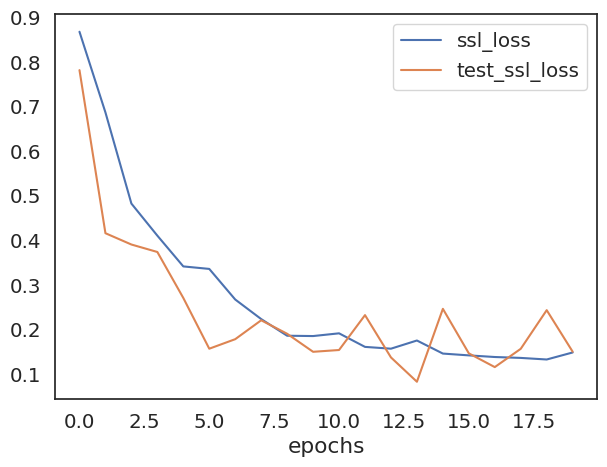

In [9]:
# Define pretraining hyperparameters
pt_args = {'lr': 1e-3, 'batch_size': 96, 'epochs': 20, 'seed':42}
pretrainer = PreTrainer(**pt_args)

# Train the model using the provided training and test datasets
# - dfcx_train: Training dataset
# - dfcx_test: Validation dataset to monitor performance
pretrainer.train(dfcx_train=tcga_train_sample,
                 dfcx_test=tcga_test_sample)

# Save the trained pretrainer model for future use
pretrainer.save('./model/my_pretrainer.pt')

## 6. Baseline Methods Usage Examples

In [10]:
# import the baseline scores
from baseline.immnue_score import immnue_score_methods

In [11]:
immnue_score_methods

{'PD1': baseline.immnue_score.PD1.PD1,
 'PDL1': baseline.immnue_score.PDL1.PDL1,
 'CTLA4': baseline.immnue_score.CTLA4.CTLA4,
 'CD8': baseline.immnue_score.CD8.CD8,
 'GeneBio': baseline.immnue_score.GeneBio.GeneBio,
 'NetBio': baseline.immnue_score.Kong_NetBio.Kong_NetBio,
 'MIAS': baseline.immnue_score.Wu_MIAS.Wu_MIAS,
 'GEP': baseline.immnue_score.Cristescu_GEP.Cristescu_GEP,
 'IMPRES': baseline.immnue_score.Auslander_IMPRES.Auslander_IMPRES,
 'TIDE': baseline.immnue_score.Jiang_TIDE.Jiang_TIDE,
 'NRS': baseline.immnue_score.Huang_NRS.Huang_NRS,
 'IFNG': baseline.immnue_score.Ayers_IFNG.Ayers_IFNG,
 'CIS': baseline.immnue_score.Davoli_CIS.Davoli_CIS,
 'IS': baseline.immnue_score.Roh_IS.Roh_IS,
 'Teff': baseline.immnue_score.Fehrenbacher_Teff.Fehrenbacher_Teff,
 'PGM': baseline.immnue_score.Freeman_PGM.Freeman_PGM,
 'CKS': baseline.immnue_score.Messina_CKS.Messina_CKS,
 'CAF': baseline.immnue_score.Nurmik_CAFs.Nurmik_CAFs,
 'CTL': baseline.immnue_score.Jiang_CTLs.Jiang_CTLs,
 'TAM': b

In [12]:
# import the baseline scores
from baseline.immnue_score import immnue_score_methods

# Below is how to extract the features using the baseline methods.
# These features can be used to develop logistic regression model for response prediction
res = []
for k, f in immnue_score_methods.items():
    baseline = f(cancer_type='SKCM', drug_target='PD1')
    s1 = baseline(df_tpm)
    res.append(s1)

pd.concat(res, axis=1).head()

[WARN] The majority(>80%) of genes with positive expression in your inputted data. Please Normalize your data
[WARN] Start normalizing the input expression profile by: 1. Do the log2(x+1) transformation. 2. Subtract the average across your samples.


,PDCD1,CD274,CTLA4,NAG_CD8,CD8B,CD8A,CD28,TRIM25,UBC,KIF2C,...,NAG_Roh_IS,NAG_Fehrenbacher_Teff,TBX3,MAP4K1,PCA_Messina_CKS,NAG_Nurmik_CAFs,NAG_Jiang_CTLs,NAG_Jiang_TAMs,NAG_Jiang_Texh,NAG_Rooney_ICA
1_ipiPD1_PRE,0.263034,0.443607,0.584963,0.075813,0.000000,0.333424,0.678072,4.095924,8.877867,2.472488,...,0.529500,0.255713,2.100978,2.220330,-5.076745,0.685883,0.297893,0.688596,0.740698,0.173749
2_ipiPD1_PRE,0.124328,0.659925,1.042644,0.459469,0.250962,1.769772,1.761285,3.675816,10.520422,3.733354,...,0.850548,0.292490,3.990955,3.568032,-4.282737,1.008657,0.423985,0.898566,1.026243,0.590691
6_ipiPD1_PRE,0.226509,0.263034,0.378512,0.370453,0.201634,1.427606,1.304511,2.916477,8.121793,1.214125,...,0.707502,0.490161,0.925999,2.508429,-2.801631,0.754903,0.527356,0.540569,0.660849,0.459451
7_ipiPD1_PRE,0.286881,0.238787,0.545968,0.645404,0.389567,2.448901,0.594549,2.056584,7.470211,1.395063,...,0.722526,0.695194,1.627607,1.761285,-1.213075,0.497768,0.527554,0.472271,0.488581,0.396062
8_ipiPD1_PRE,0.189034,0.584963,0.978196,0.535612,0.344828,2.010780,3.321928,4.436961,8.370426,3.837943,...,0.709227,0.736650,1.028569,2.680324,-2.420211,1.002617,0.582450,0.794207,0.931874,0.254326


## 7. Additional Information

This section provides detailed information to help you get started with the Compass project. We explain how to generate the necessary inputs from raw FASTQ data and introduce our online web server that supports both prediction and feature extraction using our pre-trained Compass models.

### Generating Compass Inputs from Raw FASTQ Data

Generating high-quality inputs is crucial for the optimal performance of the Compass models. Our comprehensive [Compass Data Pre-Processing Guide](https://www.immuno-compass.com/help/index.html) walks you through the entire workflow, ensuring that your raw FASTQ data is processed into a robust format ready for accurate predictions and feature extraction.

### Online Web Server for Prediction and Feature Extraction

To simplify the use of our models, we offer an online web server that enables you to interact directly with the Compass models without local installations. The web server provides two primary functionalities:

- **Prediction:** Submit your processed data to generate model predictions using our [online prediction tool](https://www.immuno-compass.com/predict).
- **Feature Extraction:** Extract key data attributes with our [feature extraction tool](https://www.immuno-compass.com/extract).

These user-friendly services are designed to streamline your workflow and integrate Compass seamlessly into your analytical processes.

### Contributing Your Own Compass Models

We welcome contributions from the community. If you have developed a Compass model that can enhance our project, we encourage you to share it. By contributing your model, you help enrich the Compass ecosystem and promote collaborative innovation. For details on how to submit your model, please refer to our contribution guidelines. You can also [join our Slack channel](https://join.slack.com/t/immuno-compass/shared_invite/zt-2znjho738-YZOfLEGLNEH5eH_0W1TmQg) to discuss and collaborate with other users.

### Citing Our Work

If you use our resources, please cite our work as follows:

Wanxiang Shen, Thinh H. Nguyen, Michelle M. Li, Yepeng Huang, Intae Moon, Daniel Marbach, and Marinka Zitnik. *Cross-cancer AI modeling of immunotherapy response* [J]. medRxiv.

---

We hope this information helps you make the most of the Compass project. If you have any questions or need further assistance, please do not hesitate to contact our support [team](https://www.immuno-compass.com/contact/index.html).
itate to contact our support team.
